<a href="https://colab.research.google.com/github/bonochof/rl-tiktactoe/blob/master/Q-Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# マルバツゲームの強化学習（Q学習）
Author: Ryosuke TAKATA (Shizuoka University)

#### 手順1: 基本ライブラリを読み込む

In [3]:
import math
import random
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
from IPython.display import clear_output

#### 手順2: ゲームを作成する

In [5]:
# プレイヤの入力を受け付ける関数
def get_player_input(play_area, player_turn):
    choosable_area = [str(area) for area in play_area if type(area) is int]

    # 入力待ち
    while(True):
        player_input = input('Choose a number >')
        if player_input in choosable_area:
            player_input = int(player_input)
            break
        else:
            print('Wrong input!\nChoose a number from {}'.format(choosable_area))
    
    # player_turn=1: 先手，player_turn=2: 後手
    if player_turn == 1:
        play_area[play_area.index(player_input)] = '○'
    elif player_turn == 2:
        play_area[play_area.index(player_input)] = '×'
    
    return play_area, player_input

In [6]:
# AIの入力を受け付ける関数
def get_ai_input(play_area, ai_turn, mode=0, q_table=None, epsilon=None):
    choosable_area = [str(area) for area in play_area if type(area) is int]

    # mode=0: ランダムAI，mode=1: Q学習AI
    if mode == 0:
        ai_input = int(random.choice(choosable_area))
    elif mode == 1:
        ai_input = get_ql_action(play_area, choosable_area, q_table, epsilon)
    
    # ai_turn=1: 先手，ai_turn=2: 後手
    if ai_turn == 1:
        play_area[play_area.index(ai_input)] = '×'
    elif ai_turn == 2:
        play_area[play_area.index(ai_input)] = '○'
    
    return play_area, ai_input

In [7]:
# ゲーム画面を表示する関数
def show_play(play_area):
    clear_output()
    plt.figure(figsize=(6, 6))
    plt.plot()
    plt.xticks([0, 5, 10, 15])
    plt.yticks([0, 5, 10, 15])
    plt.tick_params(labelbottom='off', bottom='off')
    plt.tick_params(labelleft='off', left='off')
    plt.xlim(0, 15)
    plt.ylim(0, 15)

    x_pos = [2.5, 7.5, 12.5]
    y_pos = [2.5, 7.5, 12.5]

    markers = ['$' + str(marker) + '$' for marker in play_area]

    marker_count = 0
    for y in reversed(y_pos):
        for x in x_pos:
            if markers[marker_count] == '$○$':
                color = 'r'
            elif markers[marker_count] == '$×$':
                color = 'k'
            else:
                color = 'b'
            plt.plot(x, y, marker=markers[marker_count], 
                     markersize=30, color=color)
            marker_count += 1
    plt.show()

In [8]:
# ゲーム終了と勝敗を判定する関数
def judge(play_area, inputter):
    end_flg = 0
    winner = 'Nobody'
    first_list = [0, 3, 6, 0, 1, 2, 0, 2]
    second_list = [1, 4, 7, 3, 4, 5, 4, 4]
    third_list = [2, 5, 8, 6, 7, 8, 8, 6]
    for first, second, third in zip(first_list, second_list, third_list):
        if play_area[first] == play_area[second] and play_area[first] == play_area[third]:
            winner = inputter
            end_flg = 1
            break
    choosable_area = [str(area) for area in play_area if type(area) is int]
    if len(choosable_area) == 0:
        end_flg = 1
    return winner, end_flg

#### 手順3: ゲームを実行する（VS ランダムAI）

In [9]:
# プレイヤとランダムAIのゲームを実行する関数
def player_vs_randomAI(first_inputter):
    inputter1 = 'YOU'
    inputter2 = 'AI'

    play_area = list(range(1, 10))
    show_play(play_area)
    inputter_count = first_inputter
    end_flg = 0
    while True:
        if (inputter_count % 2) == 1:
            print('Your turn!')
            play_area, player_input = get_player_input(play_area, first_inputter)
            show_play(play_area)
            winner, end_flg = judge(play_area, inputter1)
            if end_flg:
                break
        elif (inputter_count % 2) == 0:
            print('AI\'s turn!')
            play_area, ai_input = get_ai_input(play_area, first_inputter, mode=0)
            show_play(play_area)
            winner, end_flg = judge(play_area, inputter2)
            if end_flg:
                break
        inputter_count += 1
    print('{} win!!!'.format(winner))

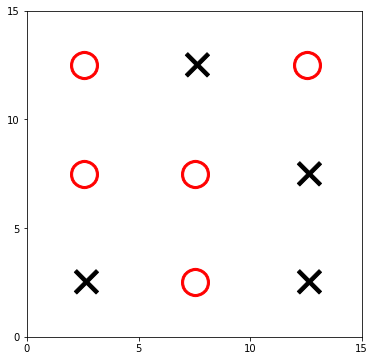

Nobody win!!!


In [10]:
player_vs_randomAI(1) # 1: プレイヤ先手，2: プレイヤ後手

#### 手順4: Q学習の処理群を作成する

In [9]:
# Qテーブルを作成する関数
def make_q_table():
    n_columns = 9
    n_rows = 3**9
    return np.zeros((n_rows, n_columns))

In [11]:
# Qテーブルを更新する関数
def q_learning(play_area, ai_input, reward, play_area_next, q_table, end_flg):
    # 行番号取得
    row_index = find_q_row(play_area)
    row_index_next = find_q_row(play_area_next)
    column_index = ai_input - 1

    # end_flg=1: 勝利or敗北
    if end_flg == 1:
        q_table[row_index, column_index] = q_table[row_index, column_index] + eta * (reward - q_table[row_index, column_index])
    else:
        q_table[row_index, column_index] = q_table[row_index, column_index] + eta * (reward + gamma * np.nanmax(q_table[row_index_next,: ]) - q_table[row_index, column_index])
    
    return q_table

In [12]:
# 状態に対応するQテーブルの行番号を計算する関数
def find_q_row(play_area):
    row_index = 0
    for index in range(len(play_area)):
        if play_area[index] == '○':
            coef = 1
        elif play_area[index] == '×':
            coef = 2
        else:
            coef = 0
        row_index += (3 ** index) * coef
    return row_index

In [13]:
# Q学習AIの行動を決定する関数
def get_ql_action(play_area, choosable_area, q_table, epsilon):
    # 探索行動
    if np.random.rand() < epsilon:
        ai_input = int(random.choice(choosable_area))
    # 貪欲行動
    else:
        row_index = find_q_row(play_area)
        first_choice_flg = 1
        for choice in choosable_area:
            if first_choice_flg == 1:
                ai_input = int(choice)
                first_choice_flg = 0
            else:
                if q_table[row_index, ai_input-1] < q_table[row_index, int(choice)-1]:
                    ai_input = int(choice)
    return ai_input

In [26]:
# ランダムAIとQ学習AIのゲームを実行する関数
def randomAI_vs_QLAI(first_inputter, q_table, epsilon=0.5):
    inputter1 = 'Random AI'
    inputter2 = 'Q-Learning AI'

    ql_input_list = []
    play_area_list = []
    play_area = list(range(1, 10))
    inputter_count = first_inputter
    end_flg = 0
    ql_flg = 0
    reward = 0
    game_count = 0 # ゲームの回数をカウントするための変数を追加します
    while True:
        # Q学習退避用
        play_area_tmp = play_area.copy()
        play_area_list.append(play_area_tmp)
        # Q学習実行フラグ
        ql_flg = 0
        # Q学習AIの手番
        if (inputter_count % 2) == 0:
            # Q学習AIの入力
            play_area, ql_ai_input = get_ai_input(play_area, first_inputter, mode=1, q_table=q_table, epsilon=epsilon)
            winner, end_flg = judge(play_area, inputter2)
            # Q学習退避用
            ql_input_list.append(ql_ai_input)            
            # Q学習AIが勝利した場合
            if winner == inputter2:
                reward = 1
                ql_flg = 1
            play_area_before = play_area_list[-1]
            ql_ai_input_before = ql_input_list[-1]
        # ランダムAIの手番
        elif (inputter_count % 2) == 1:
            play_area, random_ai_input = get_ai_input(play_area, first_inputter+1, mode=0)
            winner, end_flg = judge(play_area, inputter1)
            # ランダムAIが勝利した場合
            if winner == inputter1:
                reward = -1
            # ランダムAIが先手の場合の初手以外は学習
            elif winner == 'Nobody':
                reward = -0.5 # 引き分けの場合の報酬を追加します
            if inputter_count != 1:
                ql_flg = 1
        # Q学習実行
        if ql_flg == 1:
            ql_ai_input_before = ql_input_list[-1]
            q_table = q_learning(play_area_before, ql_ai_input_before, reward, play_area, q_table, end_flg)
        if end_flg:
            break
        inputter_count += 1
        game_count += 1 # ゲームの回数をインクリメントします
    print('{} win!!!'.format(winner))
    return winner, q_table


#### 手順5: Q学習を実行する

In [29]:
q_table = make_q_table()
eta = 0.1  # 学習率
gamma = 0.9  # 時間割引率
initial_epsilon = 0.5  # ε
episode = 10000000
# エピソード数

In [30]:
# ランダムAI vs Q学習AI
# 1〜2分かかります
winner_list = []
for i in range(episode):
    epsilon = initial_epsilon * (1 - i / episode) # エクスプロレーション率を時間経過により調整します(10000は適当な値なので適宜調整してください)
    #epsilon = initial_epsilon * (episode-i) / episode
    winner, _ = randomAI_vs_QLAI(1, q_table, epsilon)
    winner_list.append(winner)

a
a
a
a
Q-Learning AI win!!!
a
a
a
a
Random AI win!!!
a
a
a
a
Q-Learning AI win!!!
a
a
a
a
a
Nobody win!!!
a
a
a
Q-Learning AI win!!!
a
a
a
a
Random AI win!!!
a
a
a
a
Q-Learning AI win!!!
a
a
a
a
Random AI win!!!
a
a
a
Random AI win!!!
a
a
a
a
Random AI win!!!
a
a
a
a
Q-Learning AI win!!!
a
a
a
Random AI win!!!
a
a
a
Random AI win!!!
a
a
a
Random AI win!!!
a
a
a
Random AI win!!!
a
a
a
a
a
Nobody win!!!
a
a
a
a
a
Nobody win!!!
a
a
a
Random AI win!!!
a
a
a
a
Random AI win!!!
a
a
a
Q-Learning AI win!!!
a
a
a
a
Q-Learning AI win!!!
a
a
a
a
Q-Learning AI win!!!
a
a
Random AI win!!!
a
a
a
a
Random AI win!!!
a
a
Random AI win!!!
a
a
a
a
Q-Learning AI win!!!
a
a
a
a
Random AI win!!!
a
a
a
Random AI win!!!
a
a
a
a
Q-Learning AI win!!!
a
a
a
a
Q-Learning AI win!!!
a
a
a
Random AI win!!!
a
a
a
a
a
Nobody win!!!
a
a
a
Random AI win!!!
a
a
a
Random AI win!!!
a
a
a
Random AI win!!!
a
a
Random AI win!!!
a
a
a
Random AI win!!!
a
a
a
a
Q-Learning AI win!!!
a
a
a
Random AI win!!!
a
a
a
a
Q-Learning AI w

KeyboardInterrupt: 

#### 手順6: 学習結果を確認する

In [25]:
print('勝利回数')
print('Random AI    :{}'.format(winner_list.count('Random AI')))
print('Q-Learning AI:{}'.format(winner_list.count('Q-Learning AI')))
print('Nobody       :{}\n'.format(winner_list.count('Nobody')))
print('Q-Learning AIの勝率')
print(winner_list.count('Q-Learning AI') / len(winner_list))

勝利回数
Random AI    :21416
Q-Learning AI:71279
Nobody       :7305

Q-Learning AIの勝率
0.71279


#### 手順7: ゲームを実行する（VS Q学習AI）

In [19]:
# プレイヤとQ学習AIのゲームを実行する関数
def player_vs_QLAI(first_inputter, q_table, epsilon=0):
    inputter1 = 'YOU'
    inputter2 = 'Q-Learning AI'

    ql_input_list = []
    play_area_list = []
    play_area = list(range(1, 10))
    show_play(play_area)
    inputter_count = first_inputter
    end_flg = 0
    ql_flg = 0
    reward = 0
    while True:
        # Q学習退避用
        play_area_tmp = play_area.copy()
        play_area_list.append(play_area_tmp)
        # Q学習実行フラグ
        ql_flg = 0
        # Q学習AIの手番
        if (inputter_count % 2) == 0:
            # Q学習AIの入力
            play_area, ql_ai_input = get_ai_input(play_area, first_inputter, mode=1, q_table=q_table, epsilon=epsilon)
            show_play(play_area)
            winner, end_flg = judge(play_area, inputter2)
            # Q学習退避用
            ql_input_list.append(ql_ai_input)            
            # Q学習AIが勝利した場合
            if winner == inputter2:
                reward = 1
                ql_flg = 1
            play_area_before = play_area_list[-1]
            ql_ai_input_before = ql_input_list[-1]
        # プレイヤの手番
        elif (inputter_count % 2) == 1:
            print('Your turn!')
            # プレイヤの入力受付
            play_area, player_input = get_player_input(play_area, first_inputter)
            show_play(play_area)
            winner, end_flg = judge(play_area, inputter1)
            # プレイヤが勝利した場合
            if winner == inputter1:
                reward = -1
            # プレイヤが先手の場合の初手以外は学習
            if inputter_count != 1:
                ql_flg = 1
        # Q学習実行
        if ql_flg == 1:
            ql_ai_input_before = ql_input_list[-1]
            q_table = q_learning(play_area_before, ql_ai_input_before, reward, play_area, q_table, end_flg)
        if end_flg:
            break
        inputter_count += 1
    show_play(play_area)
    print('{} win!!!'.format(winner))
    sleep(1)
    return winner, q_table

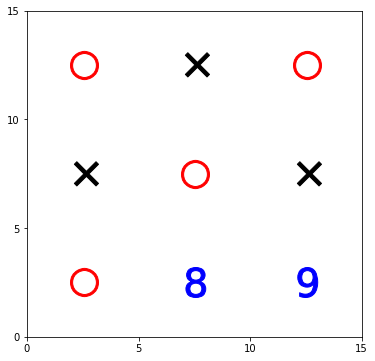

YOU win!!!


In [20]:
winner, q_table = player_vs_QLAI(1, q_table, epsilon=0)